# README

Ce notebook a été utilisé pour construire le script de l'API et tester les différentes fonctionnalités.

In [ ]:
import torch
from classes import MambaClassifier
from transformers import AutoModel
from constants import MAMBA_HIDDEN_SIZES, MODEL_CARD, ROOT_FOLDER
from constants import N_CLASSES, LABEL2IDX, LABELS
from PIL import Image
import base64
from io import BytesIO
from pydantic import BaseModel
from fastapi import UploadFile
from pathlib import Path
import uuid
import shutil

In [7]:
# transformer un tensor vers une image PIL
def tensor_to_pil(tensor):
    tensor = tensor.squeeze(0)
    tensor = tensor.permute(1, 2, 0)  # Change the order of dimensions
    tensor = (tensor * 255).byte().numpy()  # Convert to uint8
    return Image.fromarray(tensor)

In [22]:
# Convertir en Base64
def img_to_base64(img: Image) -> str:
    buffer = BytesIO()
    img.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

In [ ]:
def decode_base64_to_image(base64_str: str) -> Image:
    image_bytes = base64.b64decode(base64_str)
    return Image.open(BytesIO(image_bytes))

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model with the MambaClassifier class
model = MambaClassifier(
    AutoModel.from_pretrained(MODEL_CARD, trust_remote_code=True),
    num_classes=N_CLASSES,
    hidden_dim=MAMBA_HIDDEN_SIZES.get(MODEL_CARD),
)

model.load_state_dict(
                    torch.load("/home/hedredo/github/oc_p9/artifacts/20250506-162559_MambaVision-T-1K_unfreezed.pth"),
                )

<All keys matched successfully>

In [56]:
def save_temp_file(upload_file: UploadFile) -> Path:
    file_extension = Path(upload_file.filename).suffix  # Récupérer l'extension (.png, .jpg, ...)
    temp_filename = f"{uuid.uuid4()}{file_extension}"  # Générer un nom unique
    temp_path = ROOT_FOLDER / "backend" / "temp" / temp_filename  # Chemin du fichier temporaire
    temp_path.parent.mkdir(parents=True, exist_ok=True)  # Créer le dossier s'il n'existe pas

    with open(temp_path, "wb") as buffer:
        shutil.copyfileobj(upload_file.file, buffer)
    
    return temp_path

In [10]:
img = Image.open("img.jpg").convert("RGB")

In [12]:
buffer = BytesIO()
img.save(buffer, format="JPEG")
encoded = base64.b64encode(buffer.getvalue()).decode("utf-8")

In [50]:
class ImagePayload(BaseModel):
    image_base64: str

In [ ]:
image = decode_base64_to_image(payload.image_base64)

In [16]:
decoded_image = decode_base64_to_image(encoded)

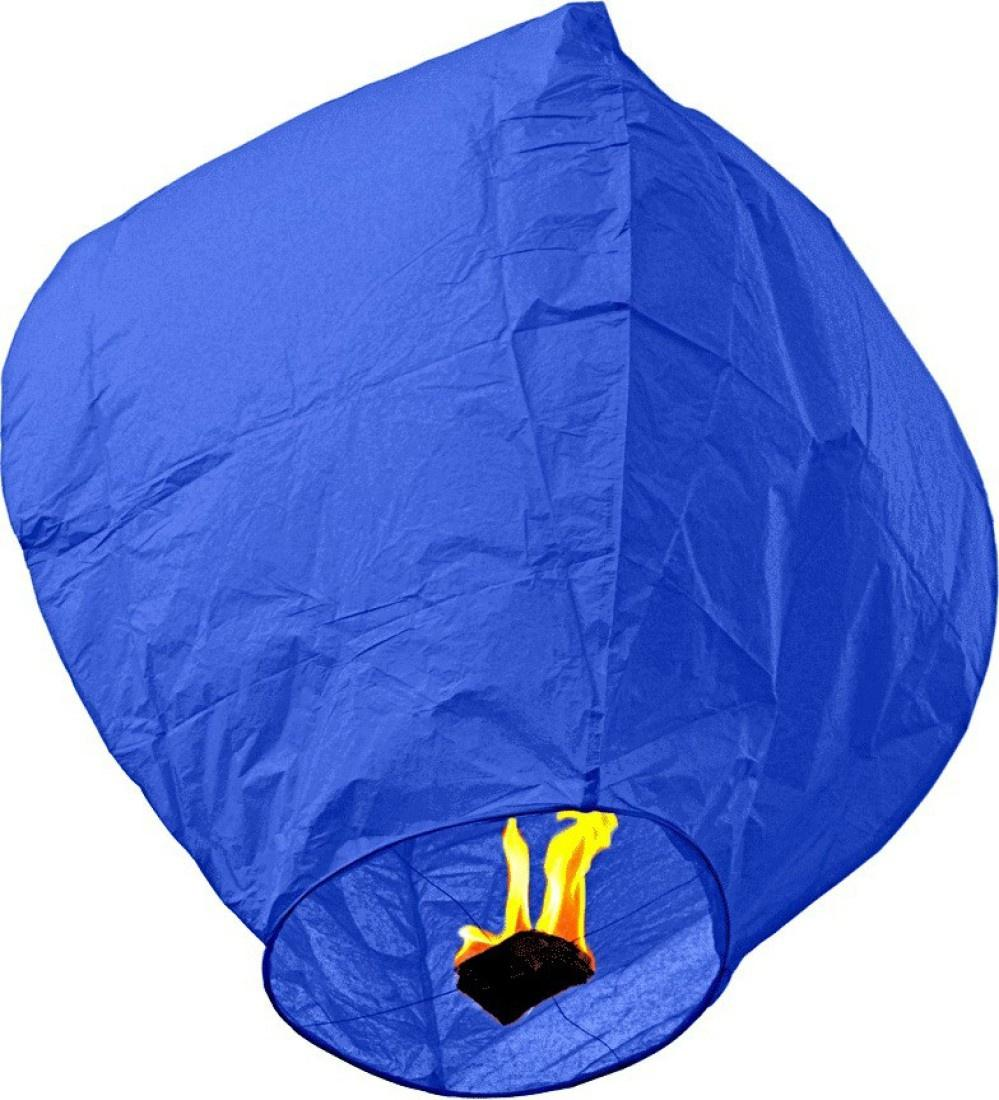

In [17]:
decoded_image.show()

In [18]:
W, H = decoded_image.size
print(f"Width: {W}, Height: {H}")

Width: 999, Height: 1100


In [14]:
type(encoded), len(encoded)

(str, 152204)

In [25]:
# BLOC TRANSFORMATION
processor = model.create_transform(training=False, auto_augment=None)
img_transformed = tensor_to_pil(processor(img))

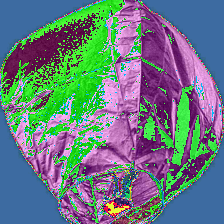

In [26]:
# display in greyscale
img_transformed.show()

In [27]:
img_transformed.size

(224, 224)

In [28]:
img_transformed_encoded = img_to_base64(img_transformed)

In [29]:
type(img_transformed_encoded), len(img_transformed_encoded)

(str, 27992)

In [30]:
model.eval()

model.to(DEVICE)
# Define the configuration for the model

img_processed = processor(img).unsqueeze(0).to(DEVICE)
# Perform inference
with torch.no_grad():
    outputs = model(img_processed)
    _, predicted = torch.max(outputs, 1)
    print(f"Predicted class: {predicted.item()}")
    print(f"Predicted class name: {LABELS[predicted.item()]}")

Predicted class: 4
Predicted class name: Home Furnishing


In [37]:
# Apply softmax to get probabilities
probs_tensor = torch.nn.functional.softmax(outputs, dim=1)

In [45]:
# Serialize the probs making it into a list
probs_serialized = probs_tensor.squeeze(0).cpu().numpy().tolist()

In [46]:
print(probs_serialized)

[0.2308119386434555, 0.021994197741150856, 0.07087205350399017, 0.03481194004416466, 0.5587416291236877, 0.046234406530857086, 0.03653382137417793]


In [48]:
{label: round(probs_serialized[idx], 2) for label, idx in LABEL2IDX.items()}

{'Baby Care': 0.23,
 'Beauty and Personal Care': 0.02,
 'Computers': 0.07,
 'Home Decor & Festive Needs': 0.03,
 'Home Furnishing': 0.56,
 'Kitchen & Dining': 0.05,
 'Watches': 0.04}